Попробуйте улучшить работу нейронной сети, рассмотренной в методическом пособии. Приложите анализ и лучшее сгенерированное изображение к уроку. Обратите внимание: для запуска нейронной сети понадобиться tensorflow 2.1.0 и минимум 8gb опер. памяти (если запускать на процессоре)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
all_cifar = np.concatenate([x_train, x_test])
all_cifar = all_cifar.astype("float32") / 255
print(all_cifar.shape)
dataset = tf.data.Dataset.from_tensor_slices(all_cifar)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

(60000, 32, 32, 3)


In [3]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=all_cifar.shape[1:]),
        layers.Conv2D(64, (3, 3), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)       

In [4]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # строим размер входного вектора 7x7x128 map
        layers.Dense(4 * 4 * 256),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((4, 4, 256)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, (3, 3), padding="same", activation="tanh"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              528384    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 16, 16, 128)       0 

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # берем случайный пример из скрытого пространства
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Строим по нему фейковое изображение
        generated_images = self.generator(random_latent_vectors)

        # собрали с реальным в тензор
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # задаем метки 1 и 0 соответственно
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Добавляем шум !!!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # учим discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        #Выбрали случайный пример в скрытом пространстве
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # собрали метки реальных изображений
        misleading_labels = tf.zeros((batch_size, 1))

        # Учим generator !
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [6]:


class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"img/{epoch}_{i}.png")

In [7]:
%%time

epochs = 200
img_nums = 5

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    dataset, 
    epochs=epochs, 
    callbacks=[GANMonitor(num_img=img_nums, latent_dim=latent_dim)]
)

Epoch 1/200
938/938 [==============================] - 155s 165ms/step - d_loss: 0.3030 - g_loss: 54.6468
Epoch 2/200
938/938 [==============================] - 144s 154ms/step - d_loss: 0.3475 - g_loss: 3.2057
Epoch 3/200
938/938 [==============================] - 146s 156ms/step - d_loss: 0.5106 - g_loss: 2.3054
Epoch 4/200
938/938 [==============================] - 150s 160ms/step - d_loss: 0.4893 - g_loss: 1.4778
Epoch 5/200
938/938 [==============================] - 151s 161ms/step - d_loss: 0.5253 - g_loss: 1.8905
Epoch 6/200
938/938 [==============================] - 150s 160ms/step - d_loss: 0.5117 - g_loss: 1.8618
Epoch 7/200
938/938 [==============================] - 151s 161ms/step - d_loss: 0.5804 - g_loss: 2.0390
Epoch 8/200
938/938 [==============================] - 151s 161ms/step - d_loss: 0.5551 - g_loss: 1.9445
Epoch 9/200
938/938 [==============================] - 148s 158ms/step - d_loss: 0.5846 - g_loss: 1.5577
Epoch 10/200
938/938 [==============================] 

938/938 [==============================] - 148s 157ms/step - d_loss: 0.5796 - g_loss: 1.2138
Epoch 155/200
938/938 [==============================] - 147s 156ms/step - d_loss: 0.5793 - g_loss: 1.2193
Epoch 156/200
938/938 [==============================] - 147s 156ms/step - d_loss: 0.5829 - g_loss: 1.2140
Epoch 157/200
938/938 [==============================] - 147s 156ms/step - d_loss: 0.5861 - g_loss: 1.2145
Epoch 158/200
938/938 [==============================] - 147s 156ms/step - d_loss: 0.5877 - g_loss: 1.2295
Epoch 159/200
938/938 [==============================] - 147s 156ms/step - d_loss: 0.5809 - g_loss: 1.2309
Epoch 160/200
938/938 [==============================] - 146s 156ms/step - d_loss: 0.5752 - g_loss: 1.2083
Epoch 161/200
938/938 [==============================] - 147s 156ms/step - d_loss: 0.5838 - g_loss: 1.2092
Epoch 162/200
938/938 [==============================] - 146s 156ms/step - d_loss: 0.5798 - g_loss: 1.2474
Epoch 163/200
938/938 [============================

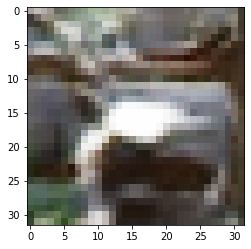

In [8]:
plt.imshow(image.load_img(f"img/{epochs-1}_0.png").convert('RGBA'))
plt.show()

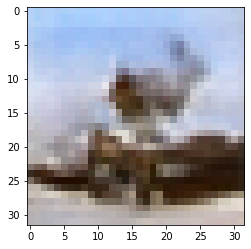

In [9]:
plt.imshow(image.load_img(f"img/{epochs-1}_1.png").convert('RGBA'))
plt.show()

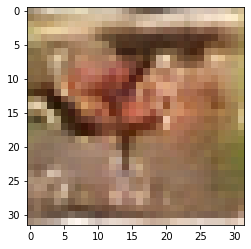

In [10]:
plt.imshow(image.load_img(f"img/{epochs-1}_2.png").convert('RGBA'))
plt.show()

Картинки вроде как напоминают что-то осмысленное, особенно по сравнению с ранними эпохами. 